# [Damped Oscillator - Numba/C++](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/damp_oscillator.ipynb)

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/damp_oscillator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import pickle
import numpy as np
import sbi.utils as utils
import matplotlib.pyplot as plt
from multiprocessing import Pool
from sbi.analysis import pairplot
from vbi.sbi_inference import Inference
from sklearn.preprocessing import StandardScaler
from vbi.models.cpp.damp_oscillator import DO

# change to numba version is compatible with current pipeline
# from vbi.models.numba.damp_oscillator import DO 

In [2]:
from vbi import report_cfg
from vbi import extract_features
from vbi import get_features_by_domain, get_features_by_given_names

In [3]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);

In [6]:
parameters = {
    "a": 0.1,
    "b": 0.05,
    "dt": 0.01,
    "t_start": 0,
    "method": "rk4",
    "t_end": 100.0,
    "t_cut": 20,
    "output": "output",
    "initial_state": [0.5, 1.0],
}

In [7]:
ode = DO(parameters)
print(ode())

Damp Oscillator model
{'a': 0.1, 'b': 0.05, 'dt': 0.01, 't_start': 0, 'method': 'rk4', 't_end': 100.0, 't_cut': 20, 'output': 'output', 'initial_state': [0.5, 1.0]}


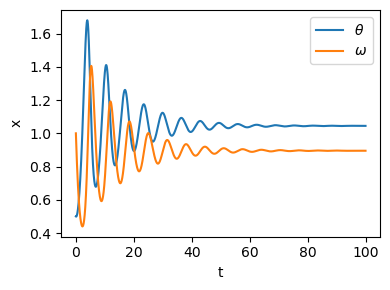

In [8]:
sol = ode.run()
t = sol["t"]
x = sol["x"]
plt.figure(figsize=(4, 3))
plt.plot(t, x[:, 0], label="$\\theta$")
plt.plot(t, x[:, 1], label="$\omega$")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.tight_layout()
plt.savefig("output/damp_oscillator_ts.jpeg", dpi=300)

In [9]:
cfg = get_features_by_domain(domain="statistical")
cfg = get_features_by_given_names(cfg, names=["calc_std", "calc_mean"])
report_cfg(cfg)

Selected features:
------------------
■ Domain: statistical
 ▢ Function:  calc_std
   ▫ description:  Computes the standard deviation of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_std
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  calc_mean
   ▫ description:  Computes the mean of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_mean
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes


In [10]:
def wrapper(par, control, cfg, verbose=False):
    ode = DO(par)
    sol = ode.run(control)

    # extract features
    fs = 1.0 / par["dt"] * 1000  # [Hz]
    stat_vec = extract_features(
        ts=[sol["x"].T], cfg=cfg, fs=fs, n_workers=1, verbose=verbose
    ).values
    return stat_vec[0]

In [11]:
def batch_run(par, control_list, cfg, n_workers=1):
    stat_vec = []
    with Pool(processes=n_workers) as pool:
        stat_vec = pool.starmap(
            wrapper, [(par, control, cfg) for control in control_list]
        )
    return stat_vec

In [12]:
control = {"a": 0.11, "b": 0.06}
x_ = wrapper(parameters, control, cfg)
print(x_)

[0.12421611 0.10675827 1.0513536  0.8769057 ]


In [13]:
num_sim = 2000
num_workers = 10
a_min, a_max = 0.0, 1.0
b_min, b_max = 0.0, 1.0
prior_min = [a_min, b_min]
prior_max = [a_max, b_max]
theta_true = {"a": 0.1, "b": 0.05}

In [14]:
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [15]:
obj = Inference()
theta = obj.sample_prior(prior, num_sim)
theta_np = theta.numpy().astype(float)
control_list = [{"a": theta_np[i, 0], "b": theta_np[i, 1]} for i in range(num_sim)]

In [16]:
stat_vec = batch_run(parameters, control_list, cfg, n_workers=4)

In [17]:
scaler = StandardScaler()
stat_vec_st = scaler.fit_transform(np.array(stat_vec))
stat_vec_st = torch.tensor(stat_vec_st, dtype=torch.float32)
torch.save(theta, "output/theta.pt")
torch.save(stat_vec_st, "output/stat_vec_st.pt")

In [18]:
theta.shape, stat_vec_st.shape

(torch.Size([2000, 2]), torch.Size([2000, 4]))

In [19]:
posterior = obj.train(theta, stat_vec_st, prior, method="SNPE", density_estimator="maf", num_threads=4)

 Neural network successfully converged after 315 epochs.train Done in 0 hours 0 minutes 39.261273 seconds


In [20]:
with open("output/posterior.pkl", "wb") as f:
    pickle.dump(posterior, f)

In [21]:
# with open("output/posterior.pkl", "rb") as f:
#     posterior = pickle.load(f)

In [22]:
xo = wrapper(parameters, theta_true, cfg)
xo_st = scaler.transform(xo.reshape(1, -1))

In [23]:
samples = obj.sample_posterior(xo_st, 10000, posterior)
torch.save(samples, "output/samples.pt")

  0%|          | 0/10000 [00:00<?, ?it/s]

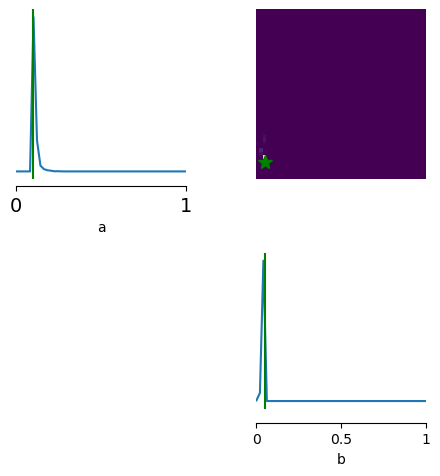

In [24]:
limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot(
    samples,
    points=[list(theta_true.values())],
    figsize=(5, 5),
    limits=limits,
    labels=["a", "b"],
    upper="kde",
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"],
    ),
)
ax[0, 0].tick_params(labelsize=14)
ax[0, 0].margins(y=0)
plt.tight_layout()
plt.savefig("output/do_cpp.jpeg", dpi=100)